In [11]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

In [2]:
data = 'WHO-COVID-19-global-data.csv'
df = pd.read_csv(data)

In [3]:
def get_country_df(country):
    df.columns = [i.strip() for i in df.columns]
    df.rename(columns={'Date_reported' : 'Date'}, inplace = True)
    df['Date'] = pd.to_datetime(df['Date'])
    country_groups = df.groupby('Country')
    country_df = country_groups.get_group(country)
    return country_df

In [4]:
def get_cases(country, how = 'New_cases', start_date = None, end_date = None):
    country_df = get_country_df(country)
    country_df.set_index('Date', inplace = True)

    if start_date is None:
        filt = country_df[how] >= 1

        country_df = country_df[filt]
    
        return country_df.loc[:, [how]]
    
    else:
        return country_df.loc[start_date:end_date, [how]]

In [5]:
def get_deaths(country, how = 'New_deaths', start_date = None, end_date = None):
    country_df = get_country_df(country)
    country_df.set_index('Date', inplace = True)

    if start_date is None:

        filt = country_df[how] >= 1

        country_df = country_df[filt]

        return country_df.loc[:, [how]]

    else:
        return country_df.loc[start_date:end_date, [how]]

In [13]:
def get_country_dictionary(countries, plot, plot_type = 'line', animate=False, start_date = None, end_date = None):
    country_dictionary = {}
    
    for i in countries:
        if plot.lower() == "new cases":
            if plot_type != 'bar':
                country_dictionary[i] = get_cases(i)
            elif plot_type == 'bar' or animate:
                country_dictionary[i] = get_cases(i, start_date=start_date, end_date=end_date)
        
        elif plot.lower() == 'total cases':
            if plot_type != 'bar':
                country_dictionary[i] = get_cases(i, 'Cumulative_cases')
                
            elif plot_type == 'bar' or animate:
                country_dictionary[i] = get_cases(i, 'Cumulative_cases', start_date=start_date, end_date=end_date)
            
        elif plot.lower() == 'new deaths':
            if plot_type != 'bar':
                country_dictionary[i] = get_deaths(i)
            
            elif plot_type == 'bar' or animate:
                country_dictionary[i] = get_deaths(i, start_date=start_date, end_date=end_date)
            
        elif plot.lower() == 'total deaths':
            if plot_type != 'bar':
                country_dictionary[i] = get_deaths(i, 'Cumulative_deaths') 
            elif plot_type == 'bar' or animate:
                country_dictionary[i] = get_deaths(i, 'Cumulative_deaths', start_date=start_date, end_date=end_date)
                
       
    country_dictionary = {
        key: country_dictionary[key] 
        for key in sorted(country_dictionary, key = lambda k: len(country_dictionary[k]))
    }
        
    return country_dictionary

In [7]:
def plot_data(countries, plot = 'new cases', plot_type = 'line'):
    
    if not (isinstance(countries, list) or isinstance(countries, tuple)):
        raise TypeError("Please pass in a list/tuple of Country/Countries")
        return
    
    # country comes in as a list
     
    %matplotlib notebook    
    plt.style.use('seaborn-colorblind')
    plt.figure(figsize=(10,5))
    plt.xticks(rotation = 45)
    
    plt.ylabel(plot.upper())
    plt.xlabel('Month')
    
    words = [(i[0].upper() + i[1:]) for i in plot.strip().split(' ')]
    to_add = '' if plot.lower().strip().split(' ')[0] != 'new' else '/Day'
    plt.title(words[0] + ' COVID-19 ' + words[1] + to_add) 
   
    
    country_dictionary = get_country_dictionary(countries, plot, plot_type)
    
    
    keys = list(country_dictionary.keys())
    
    print(country_dictionary.keys())
    
    i = -1#len(countries) // 2 - len(countries)
    width = 0.5
    x_indices = None
    
    
    if plot_type == 'bar':
        longest = country_dictionary[keys[0]]
        
        start_date, end_date = (longest.index[0], longest.index[-1])
        
        country_dictionary = get_country_dictionary(countries, plot, plot_type, start_date, end_date)
        
        x_indices = np.arange(len(country_dictionary[keys[0]]))
            
    
    for country in countries:   
        dates = country_dictionary[country].index

        if plot.lower() == "new cases":
            y = country_dictionary[country]['New_cases']
        
        elif plot.lower() == 'total cases':
            y = country_dictionary[country]['Cumulative_cases']
            
        elif plot.lower() == 'new deaths':
            y = country_dictionary[country]['New_deaths']
            
        elif plot.lower() == 'total deaths':
            y = country_dictionary[country]['Cumulative_deaths']
        
        if plot_type == 'line':
            plt.plot(dates, y, label = country, alpha = 0.75)
        
        else:
            plt.bar(x_indices + i * width , y, label = country, width = width, alpha = 0.75) 

            i += 1
#     if plot_type == 'bar':        
#         plt.xticks(ticks = x_labels, labels = country_dictionary[countries[0]].index)
    
    
    plt.legend()


<IPython.core.display.Javascript object>


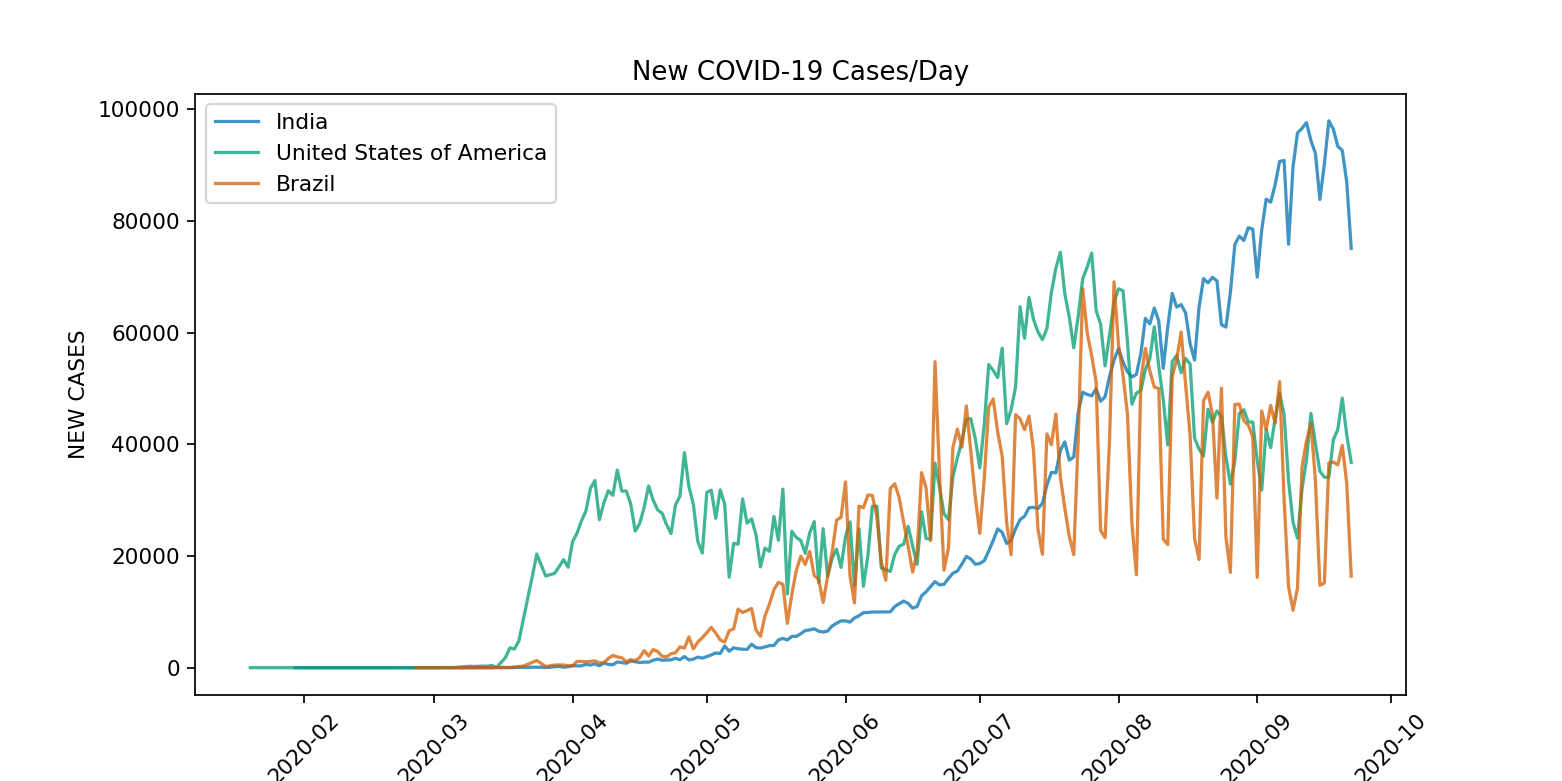

dict_keys(['India', 'United States of America', 'Brazil'])


In [8]:
plot_data(countries = ['India', 'United States of America', 'Brazil'], plot_type = 'line')

In [48]:
def plot_pie(date, plot = 'total cases'):
    df1 = pd.read_csv(data)

    df1.rename(columns = {'Date_reported' : "Date"}, inplace = True)
    df1.columns = [i.strip() for i in df1.columns]
    
    d = {
        'total cases' : "Cumulative_cases",
        'new cases' : 'New_cases',
        'total deaths' : 'Cumulative_deaths',
        'new deaths' : 'New_deaths'
    }
    
    all_cases = df1.groupby("Date").get_group(date).sort_values(by = d[plot], ascending = False)[d[plot]]
    cases = all_cases / np.sum(all_cases)
    cases = np.append(cases[:10],np.sum(cases[10:]))

    labels = df1.groupby("Date").get_group(date).sort_values(by = d[plot], ascending = False)['Country'][:10]
    labels = np.append(labels, np.array(['others']))
    
    
    plt.figure(figsize=(10,5))
    plt.style.use('seaborn-colorblind')
    plt.tight_layout()
    plt.text(-3,-1.5,s = f'Total Shared Cases = {np.sum(all_cases[:10])}')
    plt.title(f'Percentage of {plot.upper()} shared by Top 10 Countries on {date}')
    plt.pie(cases,autopct='%1.0f%%', labels = labels, pctdistance = 0.9, radius = 1.3, textprops={'size': 'smaller'});


<IPython.core.display.Javascript object>


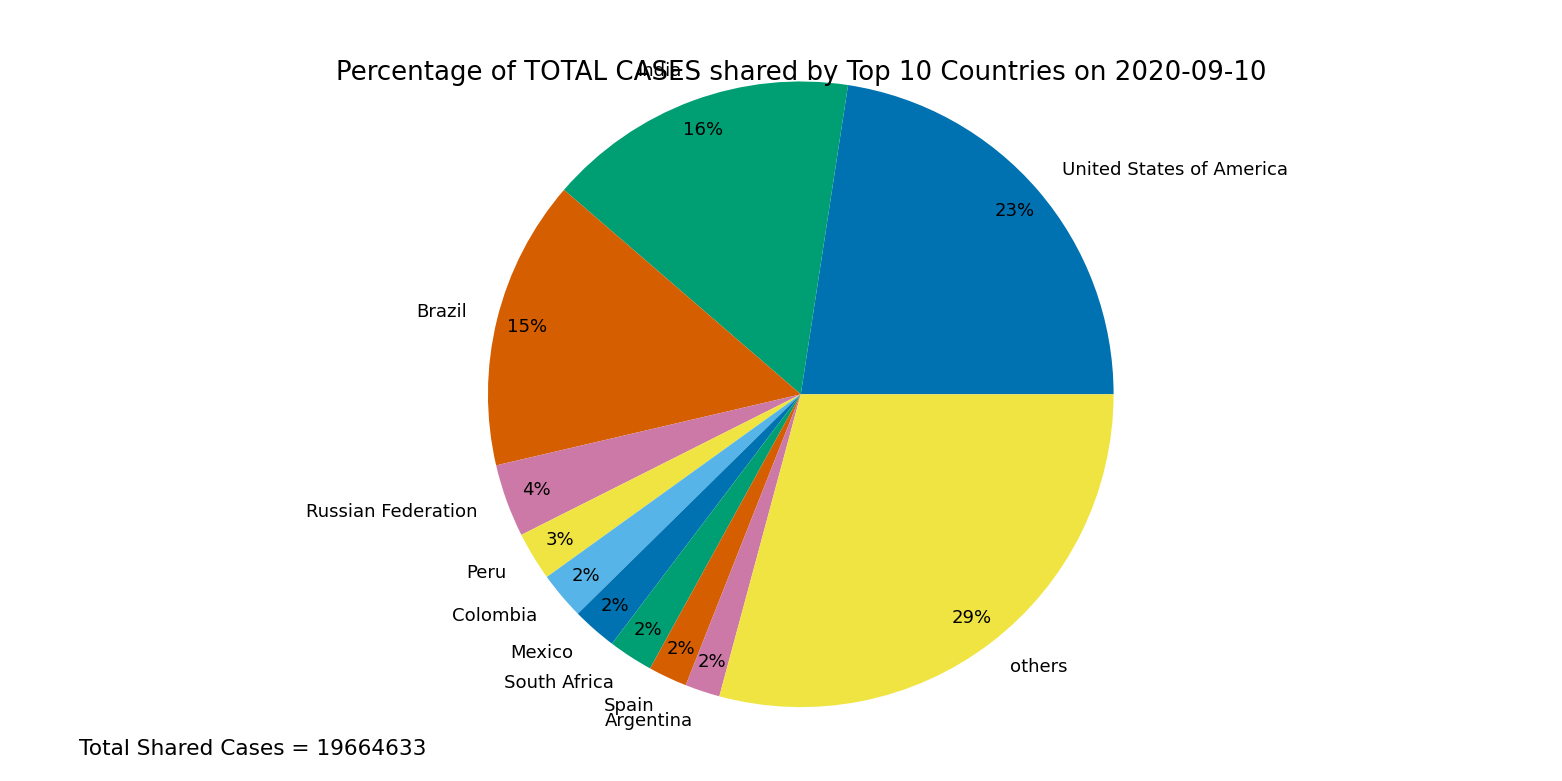

In [50]:
plot_pie('2020-09-10', 'total cases')

In [31]:
def animate(interval, countries, plot = 'new cases', plot_type = 'line'):
    print('\n\n ANIMATE CALLED \n\n')
    
    # max countries = 3 otherwise it can be clustered
    if not (isinstance(countries, list) or isinstance(countries, tuple)):
        raise TypeError("Please pass in a list/tuple of country/countries")
        return
    
    #def get_country_dictionary(countries, plot, plot_type = 'line', animate = False, start_date = None, end_date = None):
    
    country_dictionary = get_country_dictionary(countries, plot, plot_type)
    
    keys = [i for i in country_dictionary.keys()]
    
    
    longest = country_dictionary[keys[0]]

    start_date, end_date = (longest.index[0], longest.index[-1])

    country_dictionary = get_country_dictionary(countries, plot, plot_type, start_date, end_date)
    
    plt.style.use('seaborn-colorblind')
    #plt.figure(figsize=(10,5))
    plt.xticks(rotation = 45)
    
    plt.ylabel(plot.upper())
    plt.xlabel('Month')
    
    words = [(i[0].upper() + i[1:]) for i in plot.strip().split(' ')]
    to_add = '' if plot.lower().strip().split(' ')[0] != 'new' else '/Day'
    plt.title(words[0] + ' COVID-19 ' + words[1] + to_add) 
    
    
    for country in countries:   
        dates = country_dictionary[country].index

        if plot.lower() == "new cases":
            y = country_dictionary[country]['New_cases']
        
        elif plot.lower() == 'total cases':
            y = country_dictionary[country]['Cumulative_cases']
            
        elif plot.lower() == 'new deaths':
            y = country_dictionary[country]['New_deaths']
            
        elif plot.lower() == 'total deaths':
            y = country_dictionary[country]['Cumulative_deaths']
        
        if plot_type == 'line':
            plt.plot(dates, y, label = country, alpha = 0.75)
        
    
    plt.legend(loc = 'upper left')    
    plt.tight_layout()

In [53]:
%matplotlib notebook  

# plt.figure(figsize=(10,5))
# FuncAnimation(plt.gcf(), animate, blit = True, interval = 1000)